In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../../../")
print(os.getcwd())

C:\Users\Milosz\thesis-recsys


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import IterableDataset
from collections import deque, namedtuple
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm

torch.set_printoptions(precision=2, sci_mode=False)
torch.manual_seed(0)

In [9]:
class SequentialStateRepresentation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=True):
        super(SequentialStateRepresentation, self).__init__()

        self.gru = nn.GRU(input_size=input_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=batch_first)

    def forward(self, items):
        # items: (batch_size, n_items, item_features)
        _, last_hidden = self.gru(items)
        return last_hidden.squeeze(0)

class Actor(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(Actor, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        self.linear1 = nn.Linear(self.in_dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.linear3 = nn.Linear(self.hidden_dim, self.out_dim)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = F.tanh(self.linear3(output))
        return output

class Critic(nn.Module):
    def __init__(self, action_dim, state_dim, projected_state_dim, hidden_dim):
        super(Critic, self).__init__()
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.projected_state_dim = projected_state_dim
        self.state_action_dim = action_dim + projected_state_dim
        self.hidden_dim = hidden_dim

        self.linear1 = nn.Linear(self.state_dim, self.projected_state_dim)
        self.linear2 = nn.Linear(self.state_action_dim, self.hidden_dim)
        self.linear3 = nn.Linear(self.hidden_dim, 1)

    def forward(self, state, action):
        output = F.relu(self.linear1(state))
        output = torch.cat((action, output), dim=1)
        output = F.relu(self.linear2(output))
        output = F.relu(self.linear3(output))
        return output

In [10]:
Transition = namedtuple(
    'Transition', 
    field_names=[
        'state', 
        'action', 
        'reward',
        'done', 
        'next_state'
    ]
)

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)
    
    def append(self, transition: Transition):
        self.buffer.append(transition)
    
    def sample(self, size: int):
        indices = np.random.choice(
            len(self.buffer), 
            size, 
            replace=size > len(self.buffer)
        )
        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in indices])
        #print(f'{states=}, {actions=}, {rewards=}, {dones=}, {next_states=}')
        states, actions, rewards, dones, next_states = (
            torch.cat(states), 
            torch.cat(actions), 
            torch.tensor(rewards).view(-1, 1),
            torch.tensor(dones), 
            torch.cat(next_states)
        )
        return states, actions, rewards, dones, next_states
    
    def __len__(self):
        return len(self.buffer)
        

# class ReplayDataset(IterableDataset):
#     def __init__(self, buffer: ReplayBuffer, epoch_size: int = int(1e3)):
#         self.buffer = buffer
#         self.epoch_size = epoch_size

#     def __iter__(self):
#         states, actions, rewards, dones, next_states = self.buffer.sample(self.epoch_size)
#         for i in range(len(dones)):
#             yield states[i], actions[i], rewards[i], dones[i], next_states[i]
    
#     def __len__(self):
#         return self.epoch_size

In [11]:
loss_fn = nn.MSELoss()

In [97]:
class DRRAgent:
    def __init__(self, env, users_items, items_attr, emb_dim, action_dim, batch_size, eps, gamma, tau):
        self.users_items = users_items
        self.items_attr = items_attr
        self.n_users = self.users_items.shape[0]
        self.n_item_features, self.n_items = self.items_attr.shape
        self.emb_dim = emb_dim
        self.action_dim = emb_dim
        self.batch_size = batch_size
        self.eps = eps
        self.gamma = gamma
        self.tau = tau
        self.warmup_steps = 1000
        
        self.env = env
        self.buffer = ReplayBuffer(capacity=int(1e6))
        
        # Neural nets
        self.item_emb = nn.Embedding(n_items, emb_dim)
        self.state_repr = SequentialStateRepresentation(input_size=self.emb_dim, hidden_size=self.emb_dim)
        self.actor = Actor(in_dim=self.emb_dim, hidden_dim=24, out_dim=self.emb_dim)
        self.target_actor = Actor(in_dim=self.emb_dim, hidden_dim=24, out_dim=self.emb_dim)
        self.critic = Critic(action_dim=self.action_dim, state_dim=self.action_dim, projected_state_dim=self.action_dim//2, hidden_dim=24)
        self.target_critic = Critic(action_dim=self.action_dim, state_dim=self.action_dim, projected_state_dim=self.action_dim//2, hidden_dim=24)

        # Initialize weights
        self.item_emb.apply(DRRAgent.init_weights)
        DRRAgent.init_weights_sequential(self.state_repr)
        self.actor.apply(DRRAgent.init_weights)
        self.critic.apply(DRRAgent.init_weights)

        # Copy weights target networks
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())
        print("Model weights initialized, copied to target")

        # Init optimizers
        optim_kwargs = {"lr": 1e-4, "betas": (0.9, 0.999), "eps": 1e-08, "weight_decay": 0.01, "amsgrad": False}
        self.state_repr_optimizer = self.init_optimizer(self.state_repr, **optim_kwargs)
        self.actor_optimizer = self.init_optimizer(self.actor, **optim_kwargs)
        self.critic_optimizer = self.init_optimizer(self.critic, **optim_kwargs)
        print("Optimizers initialized")

        

    def train(self, epochs):
        """
        T: Maximal number of episodes
        """
        actor_losses = []
        critic_losses = []
        
        for idx, sess in tqdm(enumerate(range(epochs))):
            episode_reward = 0
            correct_count = 0
            steps = 0
            q_loss = 0
            mean_action = 0
            done_i = 0
            
            user_id, items_ids, done = self.env.reset()
            while not done:
                with torch.no_grad():
                    items_emb = self.item_emb(torch.tensor(items_ids).unsqueeze(0)).detach()
                    state = self.state_repr(items_emb).detach()

                    if np.random.uniform() < self.eps:
                        action = torch.from_numpy(0.1 * np.random.rand(self.action_dim)).unsqueeze(0).float()
                    else:
                        action = self.actor(state)

                    recommended_item = self.recommend_item(action)

                    next_items_ids, reward, done, _ = self.env.step(recommended_item)
                    next_items_emb = self.item_emb(torch.tensor(next_items_ids).unsqueeze(0)).detach()
                    next_state = self.state_repr(next_items_emb).detach()

                self.buffer.append(Transition(state, action, reward, done, next_state))

                #if len(self.buffer) > self.batch_size:
                if len(self.buffer) > self.warmup_steps:
                    critic_loss, actor_loss, critic_params_norm = self.training_step()

                    actor_losses.append(actor_loss)
                    critic_losses.append(critic_loss)

                    #print(f"Episode: {sess} | Timestep: {done_i} | Actor Loss: {actor_loss} | Critic Loss: {critic_loss}")

                done_i += 1

        return {"actor_losses": actor_losses, "critic_losses": critic_losses}


    def training_step(self):
        sample = self.buffer.sample(self.batch_size)
        batch_states, batch_actions, batch_rewards, batch_dones, batch_next_states = sample

        # ---------------------------- Update Critic Network ---------------------------- #

        # Calculate Critic loss
        critic_loss = self.compute_dqn_loss(batch_states,
                                            batch_actions,
                                            batch_rewards,
                                            batch_next_states)
        # Minimize loss, update parameters, update priorities
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_param_norm = torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_optimizer.step()


        # ----------------------------- Update Actor Network ---------------------------- #

        self.actor_optimizer.zero_grad()
        self.state_repr_optimizer.zero_grad()

        # Compute actor loss
        actions_pred = self.actor(batch_states)
        actor_loss = -self.critic(batch_states, actions_pred).mean()

        # Minimize the loss
        actor_loss.backward(retain_graph=True)
        self.actor_optimizer.step()
        self.state_repr_optimizer.step()


        # ----------------------- Soft update the target networks ----------------------- #
        self.soft_update(self.critic, self.target_critic, self.tau)
        self.soft_update(self.actor, self.target_actor, self.tau)


        return critic_loss.item(), actor_loss.item(), critic_param_norm


    def init_weights(m):
        if hasattr(m, 'weight'):
            nn.init.orthogonal_(m.weight.data)
        if hasattr(m, 'bias'):
            nn.init.constant_(m.bias.data, 0)

    def init_weights_sequential(m):
        for name, param in m.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
            if "bias" in name:
                nn.init.uniform_(param)

    def init_optimizer(self, net, **kwargs):
        return torch.optim.Adam(net.parameters(), **kwargs)

    @torch.no_grad()
    def recommend_item(self, action):
        recommended_items = list(self.env.recommended_items)
        items_to_recommend_ids = np.setdiff1d(np.arange(n_items), recommended_items)
        items_to_recommend_ids_tensor = torch.from_numpy(items_to_recommend_ids).unsqueeze(0)
        items_to_recommend_emb = self.item_emb(items_to_recommend_ids_tensor).squeeze(0).view(self.emb_dim, -1)

        recommendation_idx = (action @ items_to_recommend_emb).argmax().item()
        return items_to_recommend_ids[recommendation_idx]

    def compute_dqn_loss(self,
                         state_batch,
                         action_batch,
                         reward_batch,
                         next_state_batch):
        '''
        :param state_batch: (torch tensor) shape = (batch_size x state_dims),
                The batched tensor of states collected during
                training (i.e. s)
        :param action_batch: (torch LongTensor) shape = (batch_size,)
                The actions that you actually took at each step (i.e. a)
        :param reward_batch: (torch tensor) shape = (batch_size,)
                The rewards that you actually got at each step (i.e. r)
        :param next_state_batch: (torch tensor) shape = (batch_size x state_dims),
                The batched tensor of next states collected during
                training (i.e. s')
        :param weights: (torch tensor) shape = (batch_size,)
                Weights for each batch item w.r.t. prioritized experience replay buffer
        :return: loss: (torch tensor) shape = (1),
                 new_priorities: (numpy array) shape = (batch_size,)
        '''

        # Extract target network Q values
        with torch.no_grad():
            next_action = self.target_actor(next_state_batch)
            Q_target = self.target_critic(next_state_batch, next_action)
      
        y = reward_batch + self.gamma * Q_target
        Q = self.critic(state_batch, action_batch)

        # with torch.no_grad():
        #     print(f'{Q_target=}')
        #     print(f'{reward_batch=}')
        #     print(f'{y=}')
        #     print(f'{Q=}')
        #     print(f'{(y-Q).flatten().pow(2).shape}')
        #     print(f'{loss_fn(Q, y.detach())=} \n{((y.detach() - Q).flatten().pow(2).mean())=}')

        # Calculate loss
        loss = (y.detach() - Q).flatten().pow(2).mean()

        return loss

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


    def evaluate(self, epochs):
        recommendation_dict = {}
        for idx, sess in tqdm(enumerate(range(epochs))):     
            user_id, items_ids, done = self.env.reset()
            user_rec_items = []
            while not done:
                with torch.no_grad():
                    items_emb = self.item_emb(torch.tensor(items_ids).unsqueeze(0)).detach()
                    state = self.state_repr(items_emb).detach()

                    if np.random.uniform() < self.eps:
                        action = torch.from_numpy(0.1 * np.random.rand(self.action_dim)).unsqueeze(0).float()
                    else:
                        action = self.actor(state)

                    recommended_item = self.recommend_item(action)


                    next_items_ids, reward, done, _ = self.env.step(recommended_item)
                    next_items_emb = self.item_emb(torch.tensor(next_items_ids).unsqueeze(0)).detach()
                    next_state = self.state_repr(next_items_emb).detach()

                    user_rec_items.append(recommended_item)

            recommendation_dict[user_id] = user_rec_items
        return recommendation_dict

In [77]:
class OfflineEnv:
    def __init__(self, user_items: pd.DataFrame, min_state_size: int, max_recommendation_trials: int):
        self.min_state_size = min_state_size
        self.max_recommendation_trials = max_recommendation_trials
        
        self.user_items = user_items
        self.user_items_len = self._get_state_len()
        self.user_items_filtered = self._filter_noninformative_users()
        self.user_index_gen = self._user_gen()
        
    def _filter_noninformative_users(self):
        return self.user_items[self.user_items_len >= self.min_state_size]

    def _get_state_len(self):
        return self.user_items.apply(len)

    def _user_gen(self):
        random_user_idx = np.array(self.user_items_filtered.index)
        np.random.shuffle(random_user_idx)
        for u in random_user_idx:
            yield u

    def reset(self):
        self.u = next(self.user_index_gen)
        self.u_items = self.user_items.loc[self.u]
        self.items = self.u_items[:self.min_state_size]
        self.done = False
        self.recommended_items = set(self.items)
        return self.u, self.items, self.done

    def step(self, action):
        if action in self.u_items and action not in self.recommended_items:
            reward = 1
            self.items = self.items[1:] + [action] # preserve `state_size` length of items list
        else:
            reward = 0
        
        self.recommended_items.add(action)

        if len(self.recommended_items) > self.max_recommendation_trials or len(self.recommended_items) >= self.user_items_len.loc[self.u]:
            self.done = True

        return self.items, reward, self.done, self.recommended_items

In [16]:
data = pd.read_pickle("data/steam/data.pkl")
edge_index_train = pd.concat((data['relations_datastore'].dataframe.train, data['relations_datastore'].dataframe.supervision))
edge_index_valid = data['relations_datastore'].dataframe.valid
users_items_train = edge_index_train.groupby("user_id")['app_id'].apply(list)
users_items_valid = edge_index_valid.groupby("user_id")['app_id'].apply(list)
items_attr = data['items_datastore'].dataframe.df
n_items = items_attr.shape[0]

In [18]:
offline_env = OfflineEnv(
    user_items=users_items_train,
    min_state_size=8,
    max_recommendation_trials=n_items//10
)
agent = DRRAgent(
    env=offline_env,
    users_items=users_items_train,
    items_attr=items_attr,
    emb_dim=16,
    action_dim=16,
    batch_size=64, 
    eps=0.1,
    gamma=0.9,
    tau=0.01,
)

Model weights initialized, copied to target
Optimizers initialized


In [19]:
history = agent.train(epochs=offline_env.user_items_filtered.shape[0]-10)

0it [00:00, ?it/s]

In [23]:
agent_backup = agent

In [83]:
lens = users_items_train[(users_items_train.index.isin(users_items_valid.index))].apply(len)
users_eval = users_items_train[users_items_train.index.isin(users_items_valid.index)][lens > 8].apply(lambda x: x[len(x)-9:])
users_items_valid = users_items_valid[users_eval.index]

In [135]:
users_eval

user_id
21                 [19, 32, 98, 108, 191, 527, 1004, 4, 707]
24               [6, 32, 82, 161, 507, 546, 555, 1072, 1116]
32             [145, 157, 165, 243, 287, 306, 745, 881, 938]
37                    [21, 29, 30, 35, 47, 73, 93, 106, 157]
74           [427, 431, 435, 572, 637, 671, 1230, 533, 1141]
                                 ...                        
3062395    [868, 927, 934, 999, 1007, 1082, 1092, 1093, 1...
3063118    [1004, 174, 368, 841, 886, 1008, 1058, 1206, 1...
3063420     [101, 124, 368, 452, 492, 841, 1004, 1206, 1222]
3063726          [106, 4, 23, 95, 190, 366, 451, 1004, 1082]
3065483        [398, 399, 409, 498, 533, 580, 638, 728, 871]
Name: app_id, Length: 18866, dtype: object

In [139]:
users_eval.combine(users_items_valid, lambda x, y: x + y)

user_id
21         [19, 32, 98, 108, 191, 527, 1004, 4, 707, 179,...
24         [6, 32, 82, 161, 507, 546, 555, 1072, 1116, 1176]
32         [145, 157, 165, 243, 287, 306, 745, 881, 938, ...
37               [21, 29, 30, 35, 47, 73, 93, 106, 157, 458]
74         [427, 431, 435, 572, 637, 671, 1230, 533, 1141...
                                 ...                        
3062395    [868, 927, 934, 999, 1007, 1082, 1092, 1093, 1...
3063118    [1004, 174, 368, 841, 886, 1008, 1058, 1206, 1...
3063420    [101, 124, 368, 452, 492, 841, 1004, 1206, 122...
3063726     [106, 4, 23, 95, 190, 366, 451, 1004, 1082, 179]
3065483    [398, 399, 409, 498, 533, 580, 638, 728, 871, ...
Name: app_id, Length: 18866, dtype: object

In [136]:
users_items_valid

user_id
21                                                [179, 857]
24                                                    [1176]
32         [289, 320, 350, 352, 368, 461, 504, 511, 513, ...
37                                                     [458]
74                                          [481, 491, 1136]
                                 ...                        
3062395                 [14, 15, 19, 25, 124, 330, 502, 971]
3063118                                                [467]
3063420                                                [394]
3063726                                                [179]
3065483                                           [394, 990]
Name: app_id, Length: 18866, dtype: object

In [140]:
offline_env_eval = OfflineEnv(
    user_items=users_eval.combine(users_items_valid, lambda x, y: x + y),
    min_state_size=9,
    max_recommendation_trials=n_items//10
)

In [141]:
def evaluate(epochs, agent):
    recommendation_dict = {}
    for idx, sess in tqdm(enumerate(range(epochs))):     
        user_id, items_ids, done = agent.env.reset()
        user_rec_items = []
        while not done:
            with torch.no_grad():
                items_emb = agent.item_emb(torch.tensor(items_ids).unsqueeze(0)).detach()
                state = agent.state_repr(items_emb).detach()

                if np.random.uniform() < agent.eps:
                    action = torch.from_numpy(0.1 * np.random.rand(agent.action_dim)).unsqueeze(0).float()
                else:
                    action = agent.actor(state)

                recommended_item = agent.recommend_item(action)

                next_items_ids, reward, done, _ = agent.env.step(recommended_item)
                next_items_emb = agent.item_emb(torch.tensor(next_items_ids).unsqueeze(0)).detach()
                next_state = agent.state_repr(next_items_emb).detach()

                user_rec_items.append(recommended_item)

        recommendation_dict[user_id] = user_rec_items
    return recommendation_dict

In [142]:
agent.env = offline_env_eval

In [143]:
evaluate_dict = evaluate(users_eval.shape[0]-1000, agent)

0it [00:00, ?it/s]

In [157]:
prec = 0.0
for key, y_pred in evaluate_dict.items():
    y_true = users_items_valid.loc[key]
    relevant = np.intersect1d(y_pred, y_true)
    #print(f'{y_true=} {y_pred=} {relevant=}')
    #print((relevant.shape[0] / len(y_true)))
    prec += (relevant.shape[0] / len(y_true))
    
prec /= len(evaluate_dict)
print(f'Precision = {prec}')

Precision = 0.0019008465867466175


In [134]:
users_items_valid.loc[93598]

[9, 293]

In [21]:
import matplotlib.pyplot as plt

def plot_losses(actor_losses, critic_losses):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    
    axs[0].plot(actor_losses, label='Actor Loss', color='blue')
    axs[0].set_title('Actor Losses')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(critic_losses, label='Critic Loss', color='red')
    axs[1].set_title('Critic Losses')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

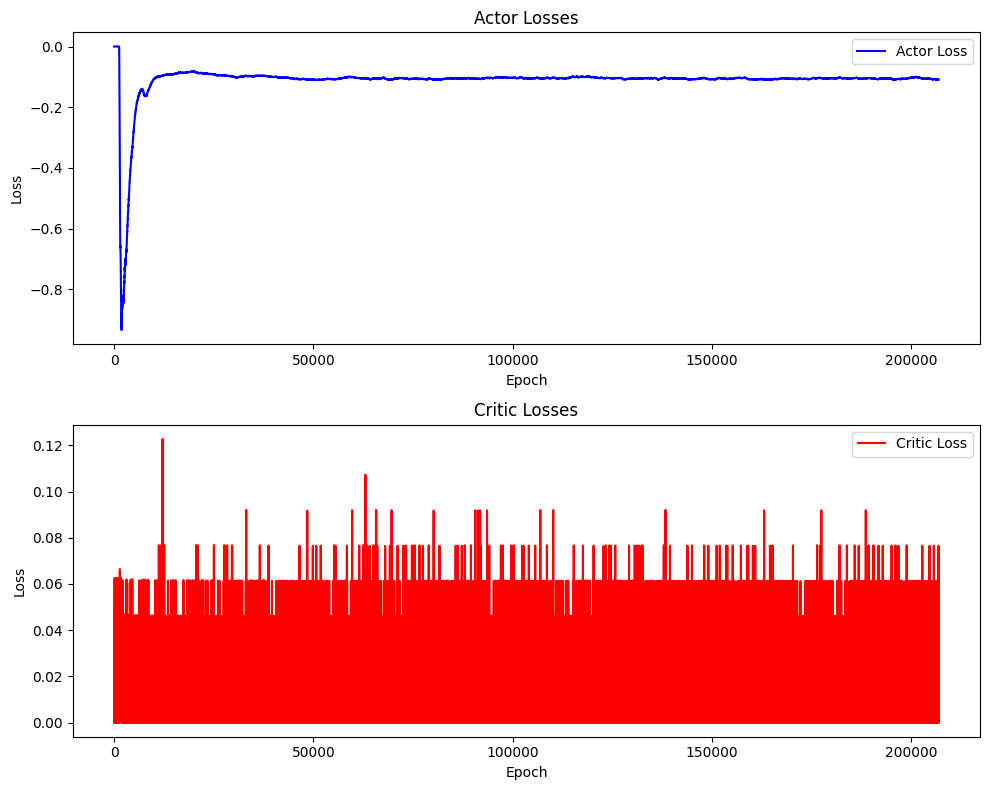

In [22]:
plot_losses(history['actor_losses'], history['critic_losses'])

In [ ]:
offline_env.user_items_filtered

In [ ]:
idx = np.array(offline_env.user_items_filtered.index)
np.random.shuffle(idx)

In [ ]:
idx

In [ ]:
offline_env.user_items_filtered.index

In [ ]:
items_emb = agent.item_emb(torch.tensor(offline_env.items).unsqueeze(0))
state = agent.state_repr(items_emb)

In [ ]:
agent.item_emb(torch.from_numpy(np.setdiff1d(np.arange(n_items), list(offline_env.recommended_items))).unsqueeze(0)).view(1, 16, -1)

In [ ]:
(state.squeeze(0) @ agent.item_emb(torch.from_numpy(np.setdiff1d(np.arange(n_items), list(offline_env.recommended_items))).unsqueeze(0)).squeeze(0).view(16, -1)).argmax().item()

In [ ]:
np.setdiff1d(np.arange(n_items), list(offline_env.recommended_items))

In [ ]:
n_items=1231
env = OfflineEnv(user_items=users_items_train, min_state_size=10, max_recommendation_trials=n_items//10)

In [ ]:
# class QNetwork(nn.Module):
#     def __init__(self, state_size, action_size):
#         super(QNetwork, self).__init__()
#         self.fc1 = nn.Linear(state_size, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, action_size)

#     def forward(self, state):
#         x = torch.relu(self.fc1(state))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [ ]:
# class ReplayBuffer:
#     def __init__(self, capacity):
#         self.capacity = capacity
#         self.buffer = []
#         self.position = 0

#     def push(self, state, action, reward, next_state, done):
#         if len(self.buffer) < self.capacity:
#             self.buffer.append(None)
#         self.buffer[self.position] = (state, action, reward, next_state, done)
#         self.position = (self.position + 1) % self.capacity

#     def sample(self, batch_size):
#         batch = np.random.choice(self.buffer, batch_size, replace=False)
#         state, action, reward, next_state, done = map(np.stack, zip(*batch))
#         return state, action, reward, next_state, done

In [ ]:
# class DQNAgent:
#     def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
#         self.q_network = QNetwork(state_size, action_size)
#         self.target_q_network = QNetwork(state_size, action_size)
#         self.target_q_network.load_state_dict(self.q_network.state_dict())
#         self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
#         self.gamma = gamma
#         self.epsilon = epsilon_start
#         self.epsilon_end = epsilon_end
#         self.epsilon_decay = epsilon_decay
#         self.action_size = action_size

#     def select_action(self, state):
#         if np.random.rand() < self.epsilon:
#             return np.random.choice(self.action_size)
#         state = torch.FloatTensor(state).unsqueeze(0)
#         q_values = self.q_network(state)
#         return torch.argmax(q_values).item()

#     def update_q_network(self, state, action, reward, next_state, done):
#         state = torch.FloatTensor(state).unsqueeze(0)
#         next_state = torch.FloatTensor(next_state).unsqueeze(0)
#         action = torch.tensor([action])
#         reward = torch.tensor([reward], dtype=torch.float32)
#         done = torch.tensor([done], dtype=torch.float32)

#         q_value = self.q_network(state).gather(1, action.unsqueeze(1))

#         next_q_value = self.target_q_network(next_state).max(1)[0].detach()
#         target_q_value = reward + (1 - done) * self.gamma * next_q_value

#         loss = nn.MSELoss()(q_value, target_q_value.unsqueeze(1))

#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()

#         # Update target Q-network
#         self.soft_update_target_network()

#         # Decay epsilon
#         self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

#     def soft_update_target_network(self, tau=0.01):
#         for target_param, param in zip(self.target_q_network.parameters(), self.q_network.parameters()):
#             target_param.data.copy_((1.0 - tau) * target_param.data + tau * param.data)

In [ ]:
# class RecommenderSystemEnv:
#     def __init__(self, edge_index, user_attributes, item_attributes):
#         self.edge_index = edge_index
#         self.user_attributes = user_attributes
#         self.item_attributes = item_attributes
#         self.state_size = user_attributes.shape[1] + item_attributes.shape[1]
#         self.action_size = item_attributes.shape[0]

#     def reset(self):
#         # Implement reset logic if needed
#         pass

#     def step(self, action):
#         # Implement the interaction logic between the agent and the environment
#         # Update the state, reward, and done flag based on the chosen action
#         pass

In [ ]:
# def train_recommender_system():
#     # Initialize environment, agent, and replay buffer
#     edge_index =  # Your edge index data
#     user_attributes =  # Your user attributes data
#     item_attributes =  # Your item attributes data
#     env = RecommenderSystemEnv(edge_index, user_attributes, item_attributes)

#     state_size = env.state_size
#     action_size = env.action_size
#     agent = DQNAgent(state_size, action_size)

#     replay_buffer = ReplayBuffer(capacity=1000)

#     num_episodes = 1000
#     batch_size = 32

#     for episode in range(num_episodes):
#         state = env.reset()
#         total_reward = 0

#         while True:
#             action = agent.select_action(state)
#             next_state, reward, done = env.step(action)
#             replay_buffer.push(state, action, reward, next_state, done)

#             if len(replay_buffer.buffer) > batch_size:
#                 batch_state, batch_action, batch_reward, batch_next_state, batch_done = replay_buffer.sample(batch_size)
#                 for i in range(batch_size):
#                     agent.update_q_network(batch_state[i], batch_action[i], batch_reward[i], batch_next_state[i], batch_done[i])

#             state = next_state
#             total_reward += reward

#             if done:
#                 break

#         print(f"Episode: {episode + 1}, Total Reward: {total_reward}")